---
title: "PCA of NPD summary statistics"
author: "Saikat Banerjee"
format:
  html: default
  ipynb: default
date: "2023-05-16"
---

# About

For multi-trait analysis of GWAS summary statistics, we look at one of the simplest models - the principal component analysis (PCA). 
The goal is to characterize the latent components of genetic associations. 
We apply PCA to the matrix of summary statistics derived from GWAS across 80 NPD phenotypes from various sources -- namely, GTEx, OpenGWAS and PGC.
For a similar comprehensive study with the UK Biobank data, see [Tanigawa et al., Nat. Comm. 2019](https://doi.org/10.1038/s41467-019-11953-9).

The $\mathbf{X}$ matrix of size $N \times P$ for the PCA is characterized by $N$ phenotypes (samples) and $P$ variants (features). 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from sklearn.decomposition import PCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

# Read summary statistics

In [2]:
data_dir = "../data"
beta_df_filename = f"{data_dir}/beta_df.pkl"
prec_df_filename = f"{data_dir}/prec_df.pkl"
beta_df = pd.read_pickle(beta_df_filename)
prec_df = pd.read_pickle(prec_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

After [filtering](preprocess_npd_gtex_pgc_ieu.ipynb), there are 8403 variants for 80 phenotypes, summarized below. 

In [3]:
#| code-fold: false

beta_df

,AD_sumstats_Jansenetal_2019sept.txt.gz,CNCR_Insomnia_all,ENIGMA_Intracraneal_Volume,IGAP_Alzheimer,Jones_et_al_2016_Chronotype,Jones_et_al_2016_SleepDuration,MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_...,MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUK...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,...,ieu-b-7,ieu-b-8,ieu-b-9,ocd_aug2017.txt.gz,pgc-bip2021-BDI.vcf.txt.gz,pgc-bip2021-BDII.vcf.txt.gz,pgc-bip2021-all.vcf.txt.gz,pgc.scz2,pgcAN2.2019-07.vcf.txt.gz,pts_all_freeze2_overall.txt.gz
rs1000031,0.002240,-0.003273,4389.4890,0.0072,0.000698,-0.000712,-0.001170,-0.005629,-0.016636,-0.046173,...,0.0124,0.000000,0.000000,-0.006995,0.012896,-0.005596,0.012798,-0.004802,-0.022505,-0.022603
rs10003281,0.005380,0.060423,-11845.8000,-0.0037,0.011744,-0.022551,0.000000,0.000000,0.000000,0.000000,...,-0.0344,0.111759,0.103478,0.097997,0.011296,-0.091501,-0.006099,0.000500,0.000000,-0.036700
rs10004866,-0.000037,0.019230,3100.2800,-0.0294,0.000277,0.008780,0.021749,0.023538,-0.000016,-0.034849,...,-0.0316,-0.027825,-0.011386,-0.035900,0.016601,0.036197,0.027002,-0.027703,-0.021801,0.015499
rs10005804,0.001255,0.005358,2291.2800,-0.0252,-0.005034,-0.005247,-0.000061,-0.003596,-0.005988,-0.024043,...,-0.0246,0.004288,-0.002221,0.042600,0.018998,-0.013703,0.005803,-0.003697,0.015002,0.020800
rs10008644,-0.002291,-0.001684,-3461.5500,0.0480,0.000000,0.000000,-0.006541,-0.011159,-0.000079,0.005927,...,-0.1204,-0.003414,0.010004,-0.049000,-0.003105,0.022603,0.006300,-0.018596,-0.036602,0.009396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9989571,-0.000085,-0.002726,5209.8665,0.0184,-0.002450,0.010379,0.001487,0.009087,0.024389,0.023753,...,-0.0383,-0.008719,0.012676,-0.100198,-0.014302,-0.054097,-0.037401,0.047999,0.028502,-0.021595
rs9991694,0.004170,-0.011018,0.0000,-0.0150,-0.007666,0.013183,-0.031620,-0.034180,-0.062177,-0.058765,...,0.0021,0.000000,0.000000,-0.185500,-0.015103,0.000800,-0.015103,0.033102,0.000000,0.017299
rs9992763,-0.001502,-0.000098,3940.5200,-0.0067,0.000568,-0.002275,-0.000704,-0.002954,0.013290,0.001284,...,0.0033,-0.000539,0.012932,-0.007899,-0.000600,0.015401,0.000100,0.004898,-0.006896,-0.018802
rs9993607,0.003670,-0.003879,-225.2632,0.0005,-0.000622,0.000486,-0.031370,-0.036475,-0.044404,-0.045986,...,-0.0161,0.001483,0.003172,-0.027897,-0.010697,-0.011901,-0.007700,-0.000700,0.003396,-0.002597


# Filter samples (phenotypes)

To eliminate unreliable estimates of genetic associations, we remove samples (phenotypes) whose mean standard error (SE) of beta value or log odds ratio is less than 0.2. The mean SE for all the 80 phenotypes are shown in @fig-se-vs-beta-std

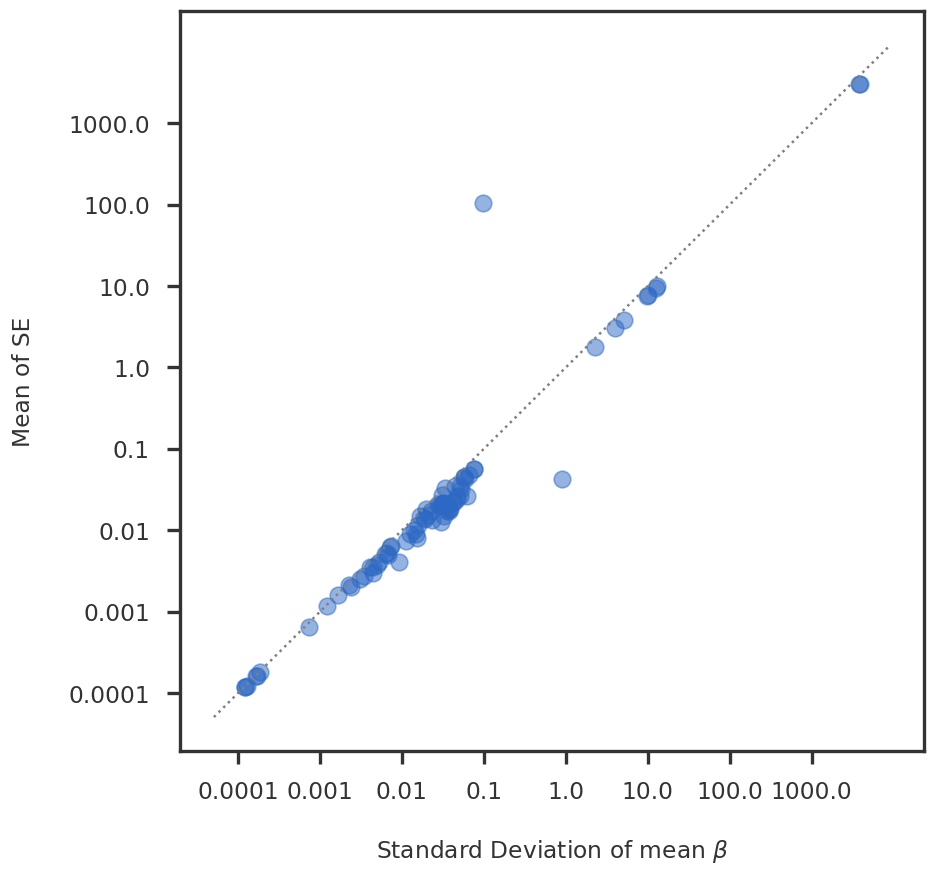

In [4]:
#| label: fig-se-vs-beta-std
#| fig-cap: "Calibration of SE against std of beta"


mean_se = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan).mean(axis = 0, skipna = True)
mean_se = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(error_df['beta_std']), np.log10(error_df['mean_se']), alpha = 0.5, s = 100)
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.set_yticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.plot_diag(ax1)
ax1.set_xlabel(r"Standard Deviation of mean $\beta$")
ax1.set_ylabel(r"Mean of SE")
plt.show()

In [5]:
#| code-fold: false

select_ids = error_df.query("mean_se <= 0.2 and beta_std <= 0.2").index

# PCA

For PCA, we center the columns of the X matrix. 

In [6]:
X = np.array(beta_df[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"We have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

We have 69 samples (phenotypes) and 8403 features (variants)


In [7]:
ncomp = min(Xcent.shape)
pca = PCA(n_components = ncomp)
pca.fit(Xcent)
beta_pcs = pca.fit_transform(Xcent)
beta_eig  = pca.components_

The variance explained by each principal component is shown in @fig-pca-variance-explained

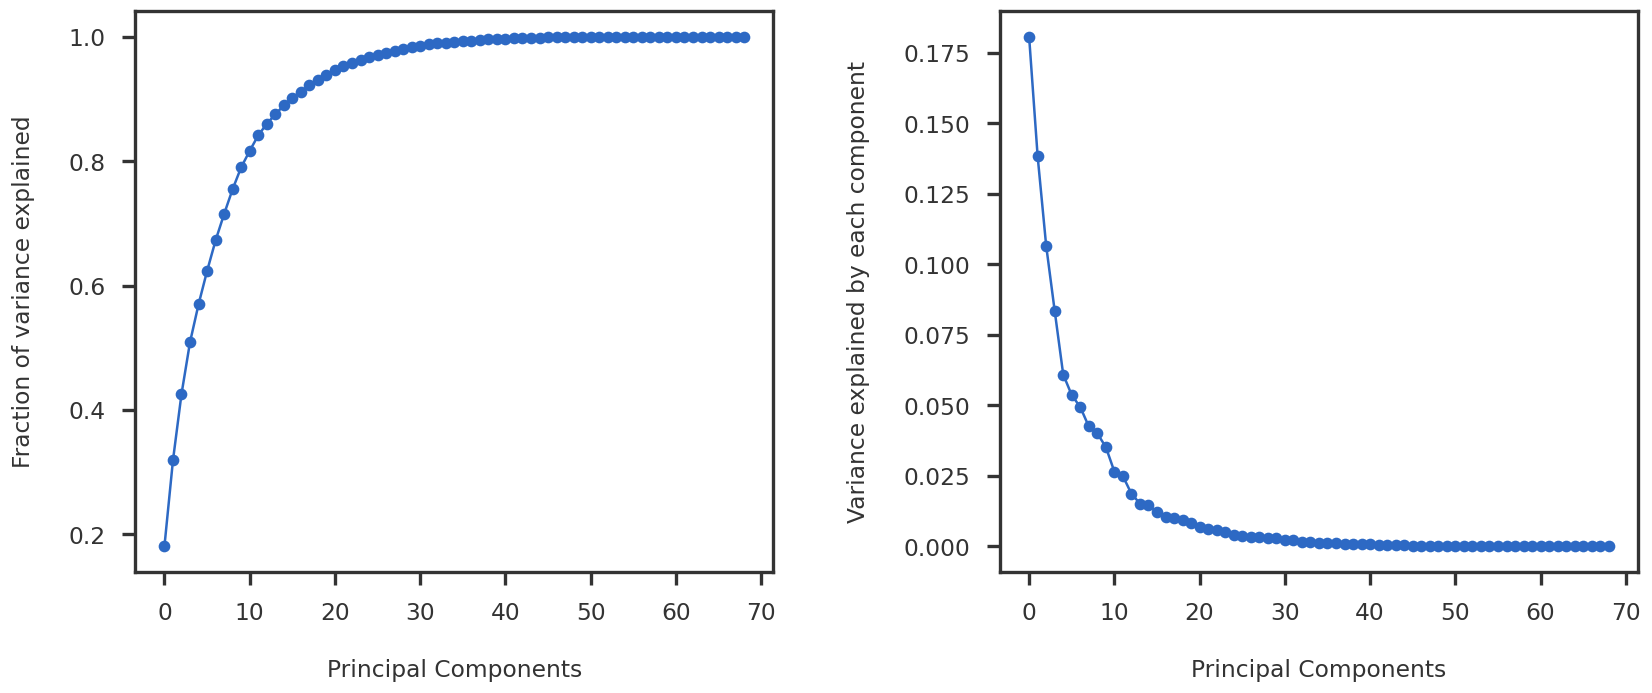

In [8]:
#| label: fig-pca-variance-explained
#| fig-cap: "Variance explained by the Principal Components"

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(np.arange(ncomp), pca.explained_variance_ratio_, s = 100, alpha = 0.7)
ax1.plot(np.arange(ncomp), np.cumsum(pca.explained_variance_ratio_), marker = 'o')
ax1.set_ylabel("Fraction of variance explained")
ax1.set_xlabel("Principal Components")

ax2.plot(np.arange(ncomp), pca.explained_variance_ratio_, marker = 'o')
ax2.set_ylabel("Variance explained by each component")
ax2.set_xlabel("Principal Components")

plt.tight_layout(w_pad = 3)
plt.show()

We plot the first 6 principal components against each other in @fig-pca-compare-components. Each dot is a sample (phenotype) colored by their broad label of NPD.

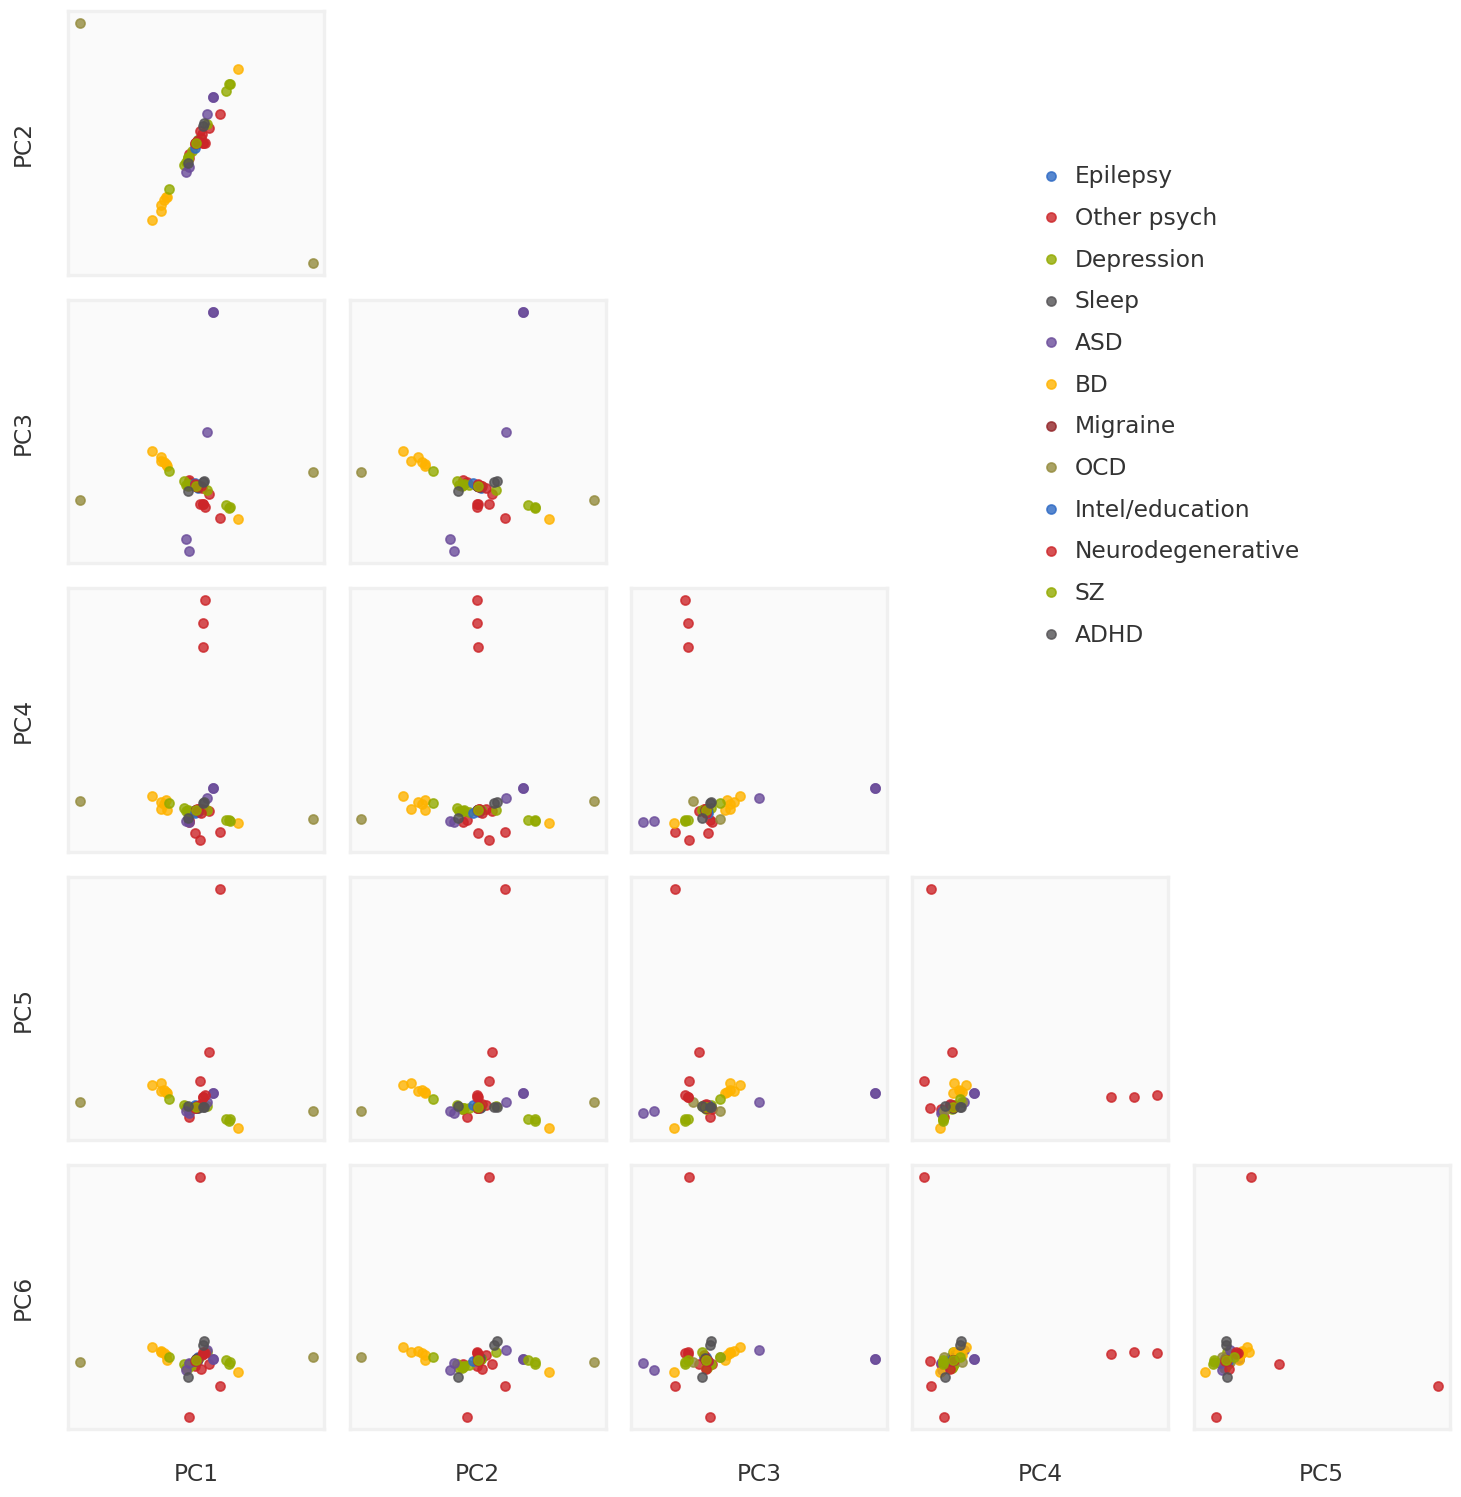

In [9]:
#| label: fig-pca-compare-components
#| fig-cap: "First 6 principal components compared against each other."

plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 30, alpha = 0.8, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, beta_pcs)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

# PCA using SVD

Just to make sure that I understand things correctly, I am redoing the PCA using SVD. It must yield the same results as `sklearn PCA`. Indeed, it does as shown in @fig-pca-svd-check.

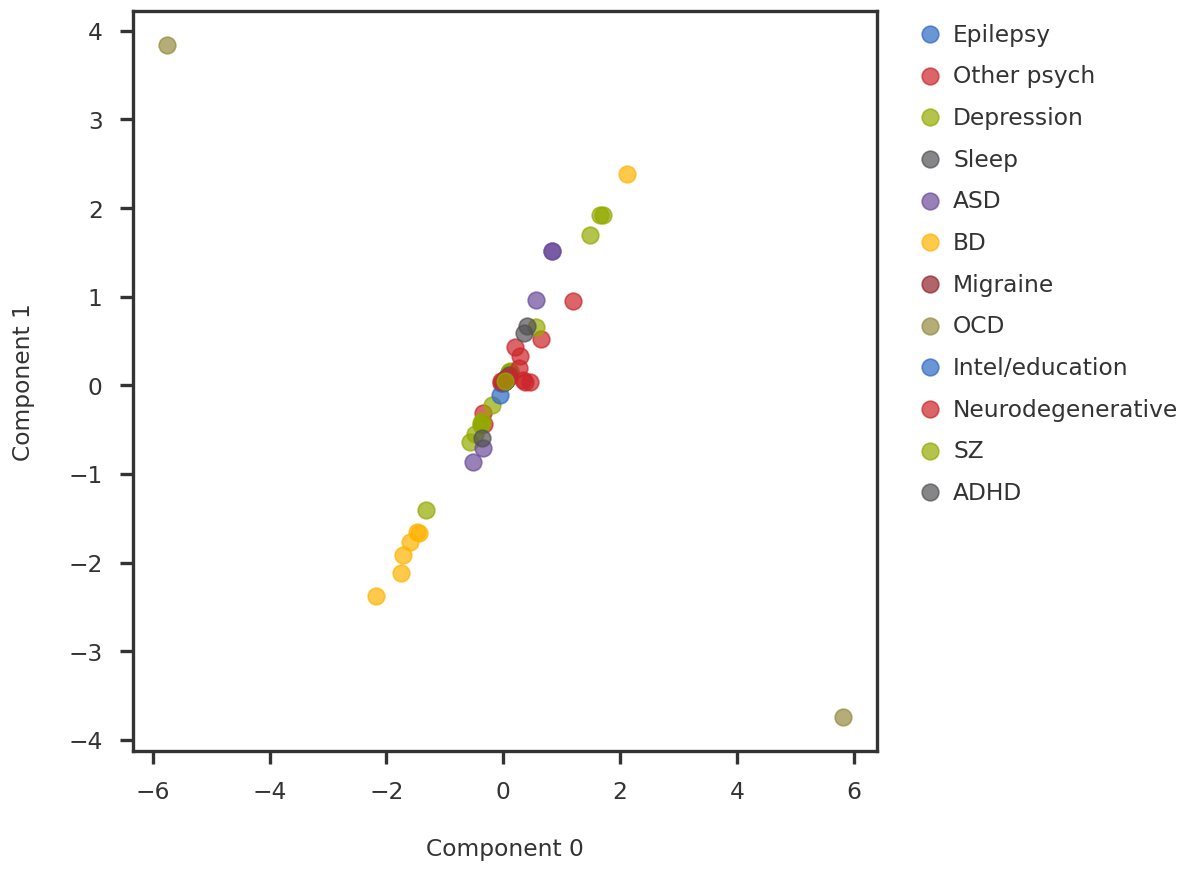

In [12]:
#| label: fig-pca-svd-check
#| fig-cap: "Check PCA using SVD."

U, S, Vt = np.linalg.svd(Xcent, full_matrices=False)
svd_pcs = U @ np.diag(S)

idx1 = 0
idx2 = 1
svd_pc1 = svd_pcs[:, idx1]
svd_pc2 = svd_pcs[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(- svd_pc1[idx], - svd_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
plt.show()

# Weighted PCA

Here, I implement the weighted covariance eigendecomposition approach algorithm proposed by L. Delchambre in 2014 ([read more](https://doi.org/10.1093/mnras/stu2219)). I use the precision matrix as the weight for each observation -- this is based on David's idea. 

In [14]:
#| code-fold: false

W = np.array(prec_df[select_ids]).T

In [15]:
def weighted_mean(x, w=None, axis=None):
    """Compute the weighted mean along the given axis

    The result is equivalent to (x * w).sum(axis) / w.sum(axis),
    but large temporary arrays are not created.

    Parameters
    ----------
    x : array_like
        data for which mean is computed
    w : array_like (optional)
        weights corresponding to each data point. If supplied, it must be the
        same shape as x
    axis : int or None (optional)
        axis along which mean should be computed

    Returns
    -------
    mean : np.ndarray
        array representing the weighted mean along the given axis
    """
    if w is None:
        return np.mean(x, axis)

    x = np.asarray(x)
    w = np.asarray(w)

    if x.shape != w.shape:
        raise NotImplementedError("Broadcasting is not implemented: "
                                  "x and w must be the same shape.")

    if axis is None:
        wx_sum = np.einsum('i,i', np.ravel(x), np.ravel(w))
    else:
        try:
            axis = tuple(axis)
        except TypeError:
            axis = (axis,)

        if len(axis) != len(set(axis)):
            raise ValueError("duplicate value in 'axis'")

        trans = sorted(set(range(x.ndim)).difference(axis)) + list(axis)
        operand = "...{0},...{0}".format(''.join(chr(ord('i') + i)
                                                 for i in range(len(axis))))
        wx_sum = np.einsum(operand,
                           np.transpose(x, trans),
                           np.transpose(w, trans))

    return wx_sum / np.sum(w, axis)

def weighted_pca_delchambre(X, W, n_components = None, regularization = None):
    
    import scipy as sp
    
    weights = weighted_mean(X, W, axis = 0).reshape(1, -1)
    _X = (X - weights) *  weights
    _covar = np.dot(_X.T, _X)
    _covar /= np.dot(weights.T, weights)
    _covar[np.isnan(_covar)] = 0

    n_components = 20
    eigvals = (_X.shape[1] - n_components, _X.shape[1] - 1)
    evals, evecs = sp.linalg.eigh(_covar, subset_by_index = eigvals)

    components = evecs[:, ::-1].T
    explained_variance = evals[::-1]
    Y = np.zeros((_X.shape[0], components.shape[0]))
    for i in range(_X.shape[0]):
        cW = components * weights[0, i]
        cWX = np.dot(cW, _X[i])
        cWc = np.dot(cW, cW.T)
        if regularization is not None:
            cWc += np.diag(regularization / explained_variance)
        Y[i] = np.linalg.solve(cWc, cWX)
    return Y, explained_variance

In [17]:
weighted_pcs, explained_variance = weighted_pca_delchambre(X, W, n_components = 20, regularization = None)

As before, the variance explained by each principal component is shown in @fig-wpca-variance-explained

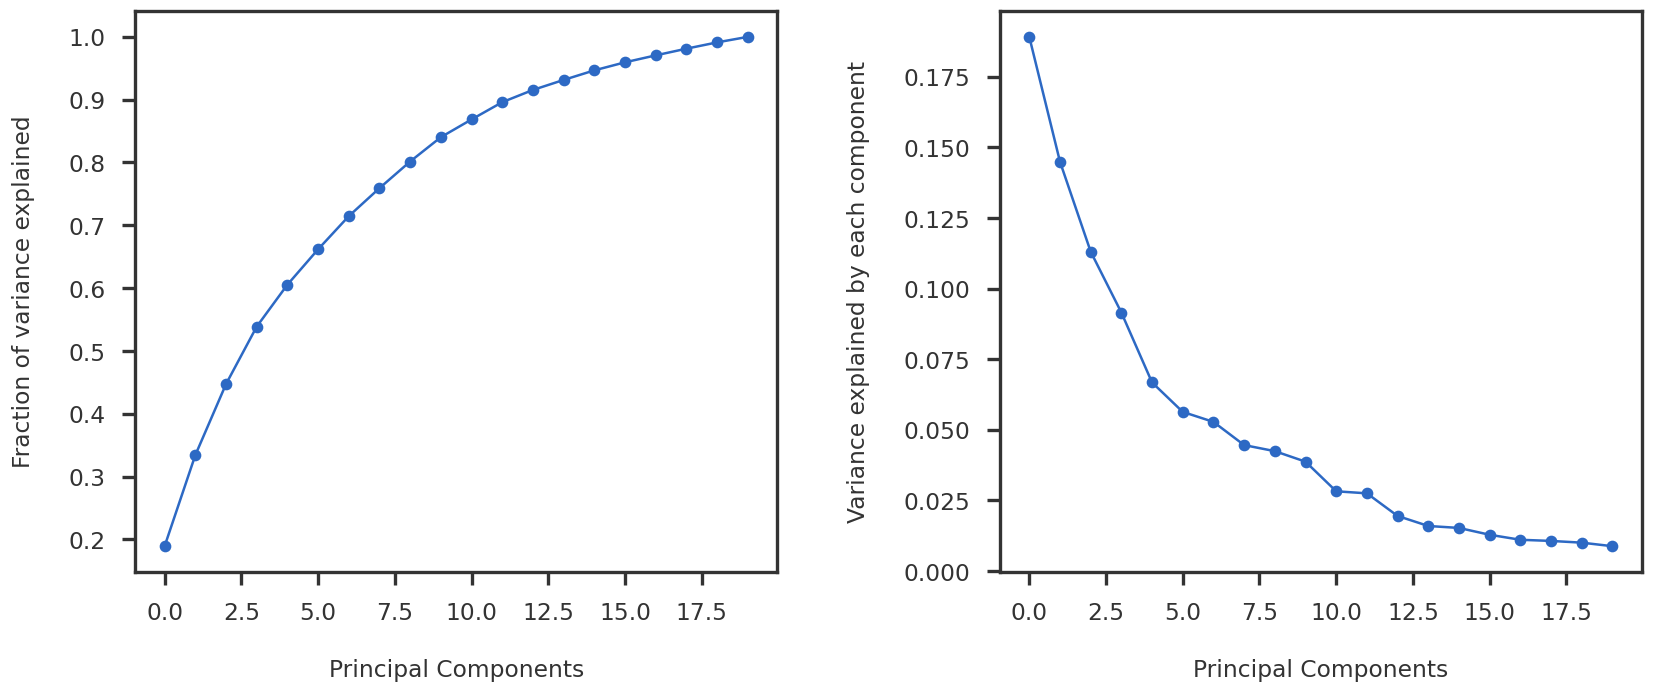

In [20]:
#| label: fig-wpca-variance-explained
#| fig-cap: "Variance explained by the weighted Principal Components"

wpca_tot_explained_variance = np.sum(explained_variance)
wpca_explained_variance_ratio = explained_variance / wpca_tot_explained_variance

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.arange(20), np.cumsum(wpca_explained_variance_ratio), marker = 'o')
ax1.set_ylabel("Fraction of variance explained")
ax1.set_xlabel("Principal Components")

ax2.plot(np.arange(20), wpca_explained_variance_ratio, marker = 'o')
ax2.set_ylabel("Variance explained by each component")
ax2.set_xlabel("Principal Components")

plt.tight_layout(w_pad = 3)
plt.show()

We plot the first 6 principal components against each other in @fig-wpca-compare-components. Each dot is a sample (phenotype) colored by their broad label of NPD.

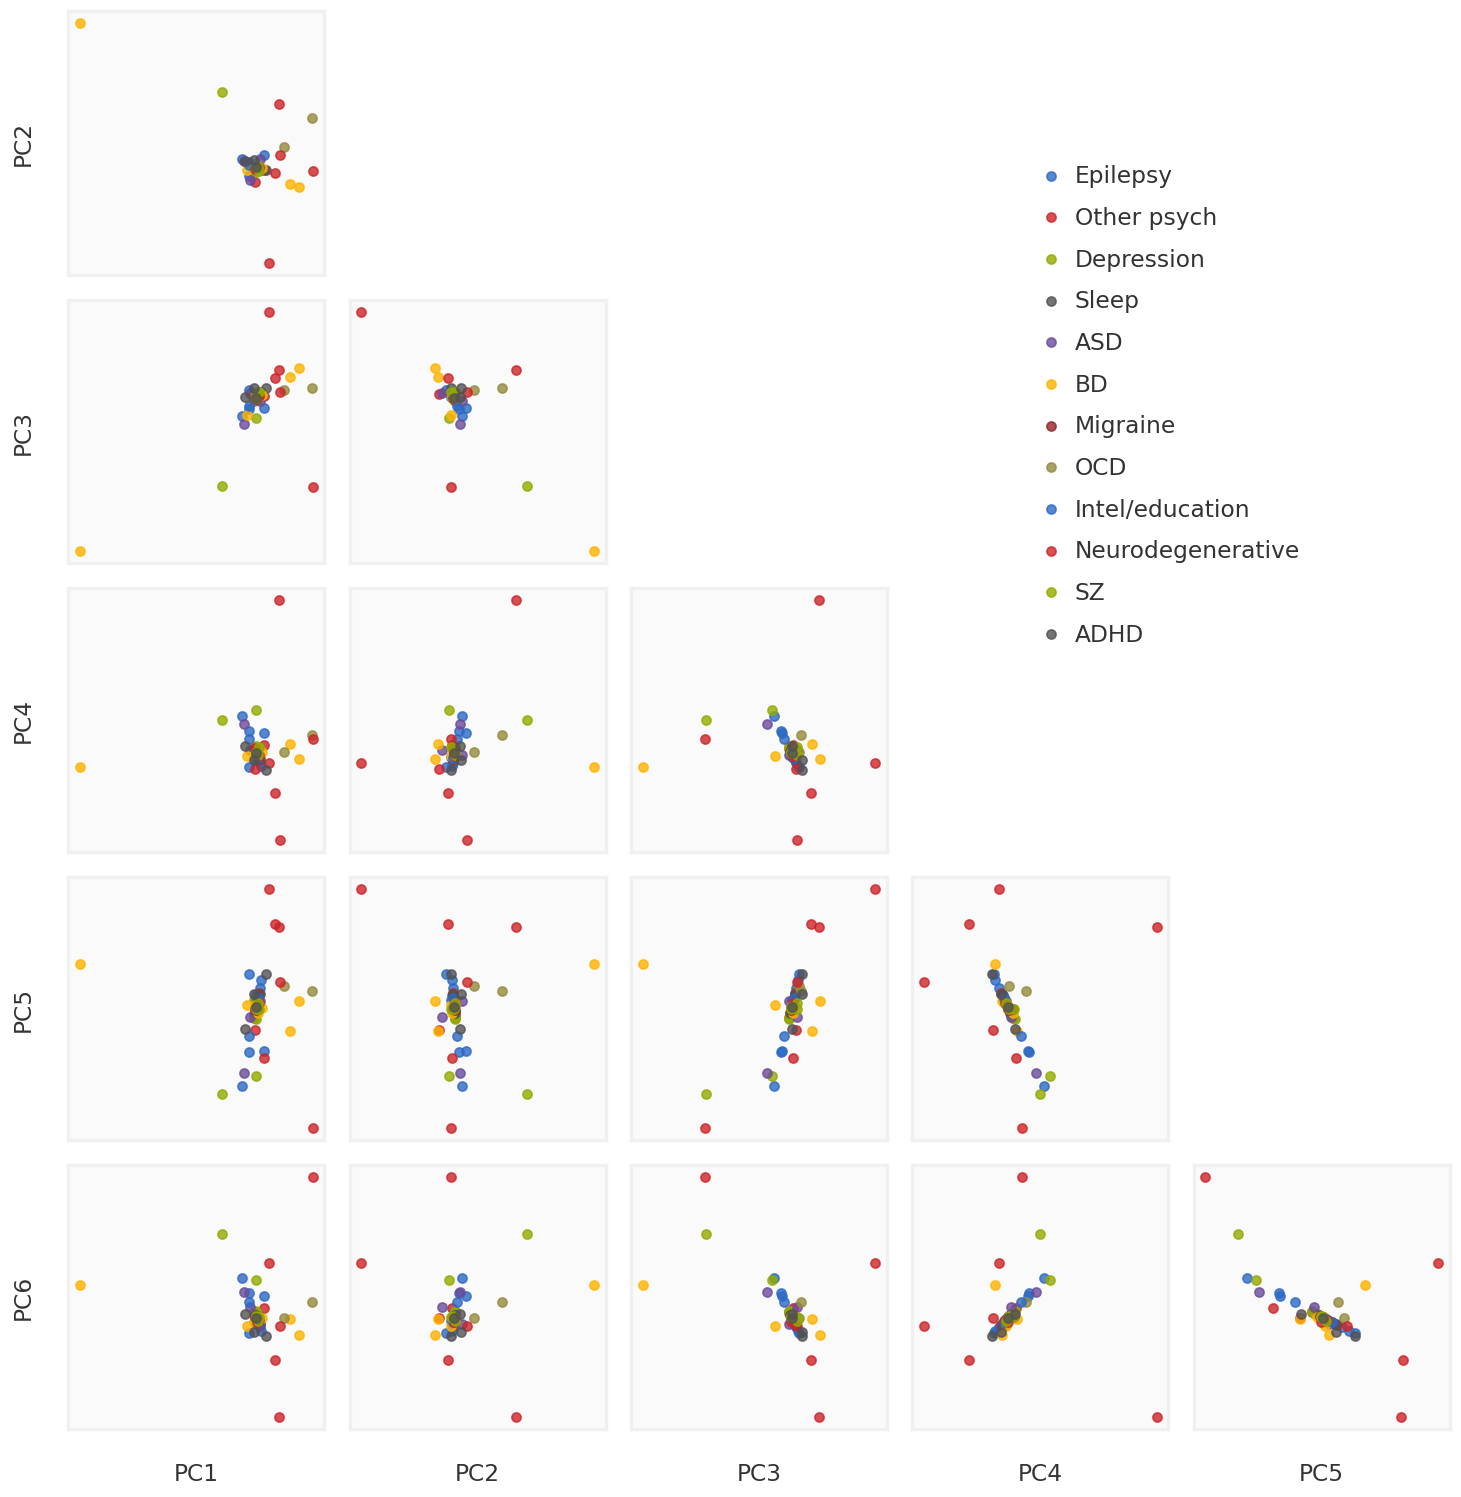

In [21]:
#| label: fig-wpca-compare-components
#| fig-cap: "First 6 weighted principal components compared against each other."

plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 30, alpha = 0.8, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, weighted_pcs)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()